# Simulate dToF Sensors

The `dtof` module of the `sensors` subpackage provides implementations for multiple dToF SPC cameras, allowing users to choose how the SPC data is captured and processed. In this tutorial we will explore three major types of SPC sensor classes.

## Simulate RawSPC

The camera simulated using `RawSPC` class generates photon cube of raw timestamps. We use the `PerPixelLoader` class to simulate different scene distances and illumination conditions.

In [ ]:
from SPCSim.data_loaders.perpixel_loaders import PerPixelLoader
from SPCSim.data_loaders.transient_loaders import TransientGenerator
from SPCSim.utils.plot_utils import plot_transient
import matplotlib.pyplot as plt
from SPCSim.sensors.dtof import RawSPC
import torch
import numpy as np


# Simulating results for distance = 0.1*dmax
PixLdr = PerPixelLoader(
                        num_dists=5,
                        min_dist = 0.2,
                        max_dist = 0.8,
                        tmax = 100,
                        sig_bkg_list = [
                            [0.2,0.2]],
                        num_runs=5,
                        device = "cpu")

# Generate the per pixel data
data = PixLdr.get_data()


# Creating transient generator with laser time period of 100ns, FWHM 1 and with
# laser time period divided into 1000 equal time-bins
tr_gen = TransientGenerator(Nr = PixLdr.Nr, Nc = PixLdr.Nc, N_tbins = 1000, tmax = PixLdr.tmax, FWHM = 2)


# Using the get function to generate the transient
# for a given distance, albedo, intensity, and illumination condition
phi_bar = tr_gen.get_transient(data["gt_dist"],
                               data["albedo"],
                               data["albedo"],
                               data["alpha_sig"],
                               data["alpha_bkg"])

Nr, Nc, N_tbins = phi_bar.shape
device = PixLdr.device

The `capture` method returns the raw_data and corresponding equi-width histogram data. The raw_data is a 3D tensor of shape `(Nr,Nc,N_output_ts)` where `N_output_ts` is the number of output timestamps per pixels.

`Note: To support vectorized computations the current implementation of RawSPC assumes one time stamp vector per laser cycle and returns 0 if no timestamp is detected for a laser cycle. (Hence N_pulses = N_output_ts)`

In [ ]:
N_output_ts = 500
N_pulses = 400

# Creating the RawSPC object with desired intrinsic properties
spc1 = RawSPC(Nr,
              Nc,
              N_pulses,
              device,
              N_tbins,
              N_output_ts)

# Captured data contains timestamps (Nr x Nc x N_output_ts) and ewh (Nr x Nc x N_tbins)
captured_data = spc1.capture(phi_bar)

# Accessing the timestamp data
raw_data = captured_data["time_stamps"]

# Accessing the corresponding ewh
ewh_data = captured_data["ewh"]

100%|██████████| 400/400 [00:00<00:00, 1028.28it/s]


The `capture` method returns a dictionary containing the raw timestamps and the captured equi-width histogram. The raw timestamps are passed to `torch.histogram` to create an equi-width histogram. The overlapping blue and red graphs indicate that `N_output_ts` is large enough to store all the time stamps detected by the camera for the complete exposure time. (Try playing with different combinations of background or signal flux or the number of laser cycles for better understanding)

raw_data torch.Size([5, 5, 500]) tensor(0.) tensor(998.5000)
torch.Size([1001]) tensor([5.0000e-01, 1.5000e+00, 2.5000e+00,  ..., 9.9850e+02, 9.9950e+02,
        1.0005e+03])


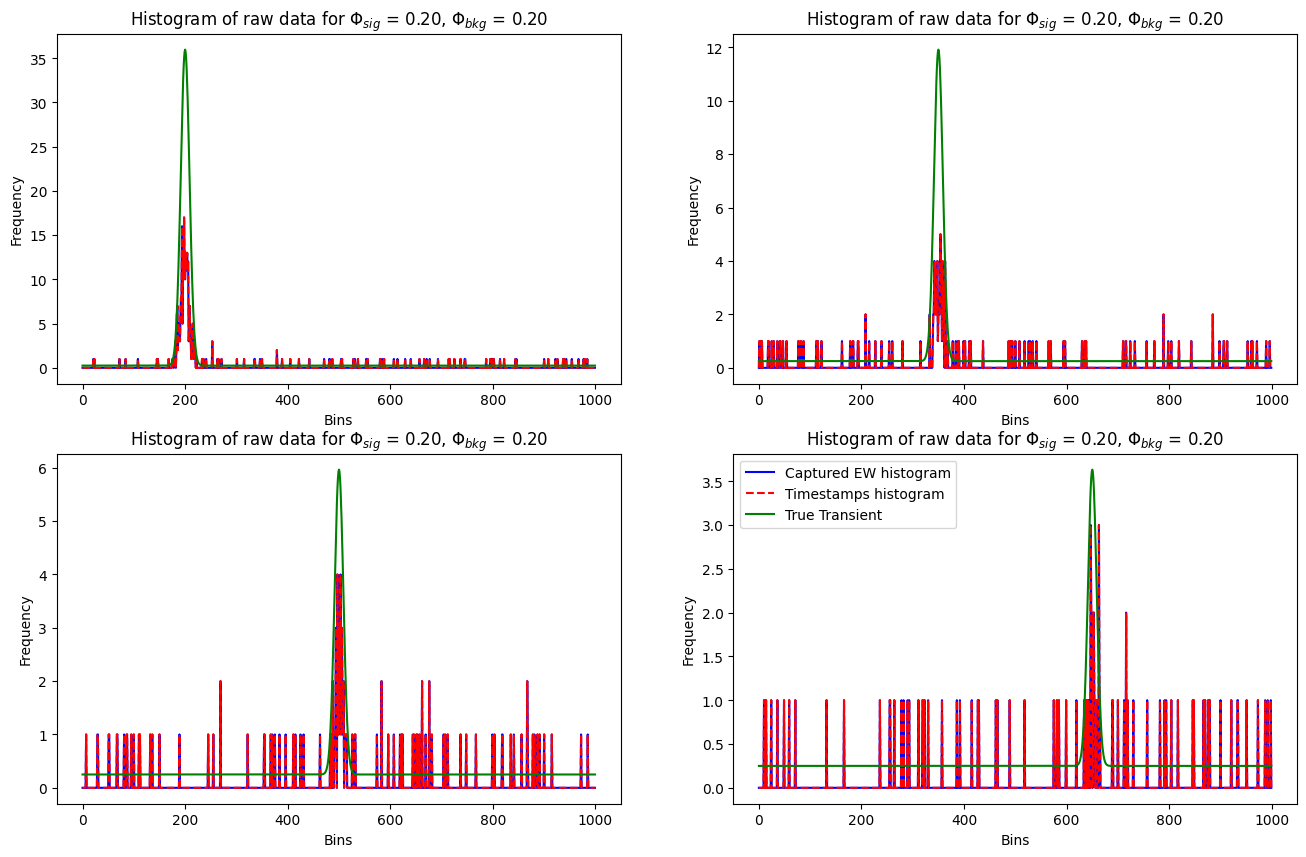

In [7]:
print("raw_data", raw_data.shape, raw_data.min(), raw_data.max())
fig, ax = plt.subplots(2,2,figsize=(16,10))
xaxis = torch.arange(0.5,1+N_tbins).to(torch.float)
print(xaxis.shape, xaxis)


# For first distance value and second run
ROW = PixLdr.get_row(sbr_idx =0, dist_idx=0)
RUN = 2
hist,_ = torch.histogram(raw_data[ROW,RUN,:], xaxis)
hist2 = ewh_data[ROW,RUN,:]
plot_transient(ax[0,0], hist2.cpu().numpy(), plt_type = '-b', label="Captured EW histogram")
plot_transient(ax[0,0], hist.cpu().numpy(), plt_type = '--r', label="Timestamps histogram")
plot_transient(ax[0,0], phi_bar[ROW,RUN,:].cpu().numpy()*spc1.N_output_ts/np.mean(np.sum(phi_bar.cpu().numpy(), axis=-1)), plt_type = '-g', label="True Transient")
ax[0,0].set_xlabel('Bins')
ax[0,0].set_ylabel('Frequency')
ax[0,0].set_title(r'Histogram of raw data for $\Phi_{sig}$ = %.2f, $\Phi_{bkg}$ = %.2f'%(data["alpha_sig"][ROW, RUN], data["alpha_bkg"][ROW, RUN]))

# For second distance value and second run
ROW = PixLdr.get_row(sbr_idx =0, dist_idx=1)
RUN = 2
hist,_ = torch.histogram(raw_data[ROW,RUN,:], xaxis)
hist2 = ewh_data[ROW,RUN,:]
plot_transient(ax[0,1], hist2.cpu().numpy(), plt_type = '-b', label="Captured EW histogram")
plot_transient(ax[0,1], hist.cpu().numpy(), plt_type = '--r', label="Timestamps histogram")
plot_transient(ax[0,1], phi_bar[ROW,RUN,:].cpu().numpy()*spc1.N_output_ts/np.mean(np.sum(phi_bar.cpu().numpy(), axis=-1)), plt_type = '-g', label="True Transient")
ax[0,1].set_xlabel('Bins')
ax[0,1].set_ylabel('Frequency')
ax[0,1].set_title(r'Histogram of raw data for $\Phi_{sig}$ = %.2f, $\Phi_{bkg}$ = %.2f'%(data["alpha_sig"][ROW, RUN], data["alpha_bkg"][ROW, RUN]))

# For third distance value and second run
ROW = PixLdr.get_row(sbr_idx =0, dist_idx=2)
RUN = 2
hist,_ = torch.histogram(raw_data[ROW,RUN,:], xaxis)
hist2 = ewh_data[ROW,RUN,:]
plot_transient(ax[1,0], hist2.cpu().numpy(), plt_type = '-b', label="Captured EW histogram")
plot_transient(ax[1,0], hist.cpu().numpy(), plt_type = '--r', label="Timestamps histogram")
plot_transient(ax[1,0], phi_bar[ROW,RUN,:].cpu().numpy()*spc1.N_output_ts/np.mean(np.sum(phi_bar.cpu().numpy(), axis=-1)), plt_type = '-g', label="True Transient")
ax[1,0].set_xlabel('Bins')
ax[1,0].set_ylabel('Frequency')
ax[1,0].set_title(r'Histogram of raw data for $\Phi_{sig}$ = %.2f, $\Phi_{bkg}$ = %.2f'%(data["alpha_sig"][ROW, RUN], data["alpha_bkg"][ROW, RUN]))

# For fourth distance value and second run
ROW = PixLdr.get_row(sbr_idx =0, dist_idx=3)
RUN = 2
hist,_ = torch.histogram(raw_data[ROW,RUN,:], xaxis)
hist2 = ewh_data[ROW,RUN,:]
plot_transient(ax[1,1], hist2.cpu().numpy(), plt_type = '-b', label="Captured EW histogram")
plot_transient(ax[1,1], hist.cpu().numpy(), plt_type = '--r', label="Timestamps histogram")
plot_transient(ax[1,1], phi_bar[ROW,RUN,:].cpu().numpy()*spc1.N_output_ts/np.mean(np.sum(phi_bar.cpu().numpy(), axis=-1)), plt_type = '-g', label="True Transient")
ax[1,1].set_xlabel('Bins')
ax[1,1].set_ylabel('Frequency')
ax[1,1].set_title(r'Histogram of raw data for $\Phi_{sig}$ = %.2f, $\Phi_{bkg}$ = %.2f'%(data["alpha_sig"][ROW, RUN], data["alpha_bkg"][ROW, RUN]))
# ax[3].set_ylim(0, N_output_ts*0.2*(PixLdr.sig_bkg_list[0][0] + PixLdr.sig_bkg_list[0][1]))
plt.legend()
plt.show()

## Simulate EWHSPC

The `BaseEWHSPC` class to simulate the conventional 3D SPCs that compress the photon timestamps into equi-width histograms. The overall pixel processing pipeline is called equi-width histogrammer (EWH).

In [50]:
from SPCSim.sensors import BaseEWHSPC
from SPCSim.utils import plot_transient, plot_ewh


# Simulating results for distance = 0.1*dmax
PixLdr = PerPixelLoader(min_dist = 0.4,
                        tmax = 100,
                        sig_bkg_list = [
                            [0.5,0.5]],
                        device = "cpu")

# Generate the per pixel data
data = PixLdr.get_data()


# Creating transient generator with laser time period of 100ns, FWHM 1 and with
# laser time period divided into 1000 equal time-bins
tr_gen = TransientGenerator(N_tbins = 1000, tmax = PixLdr.tmax, FWHM = 2)


# Using the get function to generate the transient
# for a given distance, albedo, intensity, and illumination condition
phi_bar = tr_gen.get_transient(data["gt_dist"],
                               data["albedo"],
                               data["albedo"],
                               data["alpha_sig"],
                               data["alpha_bkg"])


# Setting the dimensions, device, number of EWH bins per pixel
# and number of laser pulses

Nr, Nc, N_tbins = phi_bar.shape
device = PixLdr.device

100%|██████████| 500/500 [00:00<00:00, 5051.02it/s]


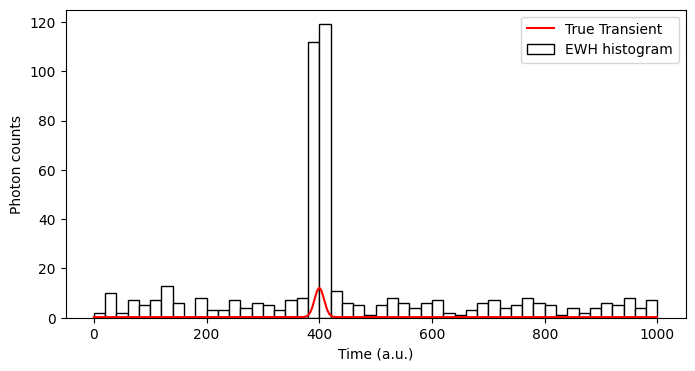

In [51]:
N_ewhbins = 50
N_pulses = 500

spc1 = BaseEWHSPC(
                Nr,
                Nc,
                N_pulses,
                device,
                N_tbins,
                N_ewhbins
               )

captured_data = spc1.capture(phi_bar)
ewh_data = captured_data["ewh"].cpu().numpy()
phi_bar = phi_bar.cpu()

ewh_bins_axis = torch.linspace(0,N_tbins-N_tbins//N_ewhbins,N_ewhbins)

fig, ax = plt.subplots(1,1,figsize=(8,4))
ROW, COL = [0,0]
plot_ewh(ax, ewh_bins_axis, ewh_data[ROW, COL,:], label = "EWH histogram", color = 'w')
plot_transient(ax, phi_bar[ROW, COL,:].numpy()*spc1.N_pulses, plt_type = '-r', label="True Transient")
ax.set_xlabel("Time (a.u.)")
ax.set_ylabel("Photon counts")
plt.legend()
# fig.savefig("Temp.png")

## Simulate basic EDH SPCs

The `BaseEDHSPC` class simulates the oracle equi-depth histogrammer (Oracle EDH). The oracle EDH has access to all the timestamps.

100%|██████████| 5000/5000 [00:00<00:00, 8819.14it/s]


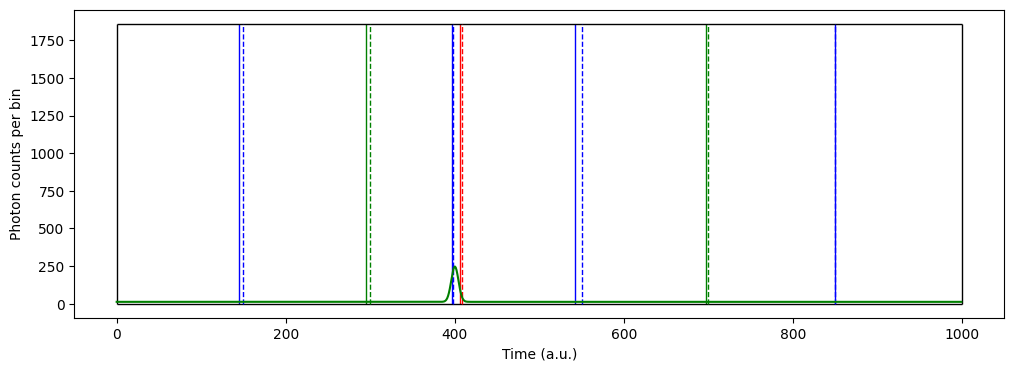

In [62]:
from SPCSim.sensors import BaseEDHSPC
from SPCSim.utils import plot_transient, plot_ewh, plot_edh


# Using the get function to generate the transient
# for a given distance, albedo, intensity, and illumination condition
phi_bar = tr_gen.get_transient(
                                data["gt_dist"],
                                data["albedo"],
                                data["albedo"],
                                data["alpha_sig"],
                                data["alpha_bkg"])


# Setting the dimensions, device, number of EWH bins per pixel
# and number of laser pulses

Nr, Nc, N_tbins = phi_bar.shape
device = PixLdr.device
N_edhbins = 8
N_pulses = 5000

spc1 = BaseEDHSPC(Nr,
              Nc,
              N_pulses,
              device,
              N_tbins,
              N_edhbins)

captured_data = spc1.capture(phi_bar)
oedh_data = captured_data["oedh"]
gtedh_data = captured_data["gtedh"]

ewh_data = captured_data["ewh"]
fig, ax = plt.subplots(1,1, figsize=(12,4))

ROW, COL = [0,0]

ymax = ((torch.sum(ewh_data[ROW,COL,:])/N_edhbins)).item()

plot_edh(oedh_data[ROW,COL,:],
         ax,
         ymax = ymax)

plot_edh(gtedh_data[ROW,COL,:], ax,
         tr = phi_bar[ROW, COL,:].numpy()*spc1.N_pulses,
        #  crop_window= tr_gen.FWHM*1.5*tr_gen.N_tbins*1.0/tr_gen.tmax, # uncoment this line to zoom into peak
         ymax = ymax, ls='--')

## Simulate hierarchical EDH SPCs

The oracle EDH is not memory efficient. Hierarchical ED histogrammers (HEDH) [[1]](https://ieeexplore.ieee.org/document/10210115) use binner circuits to iteratively update the estimates for ED histogram boundaries.

3000


100%|██████████| 3000/3000 [00:08<00:00, 374.34it/s]


(3000, 7)
torch.Size([7])


Text(0.5, 1.0, 'HEDH CV trajectories for $\\Phi_{sig}$ = 0.50, $\\Phi_{bkg}$ = 2.50, 3000 pulses')

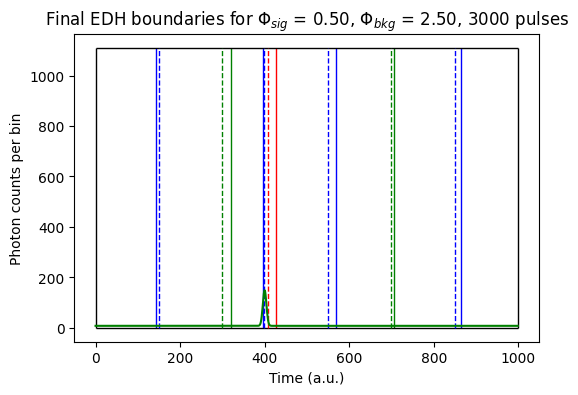

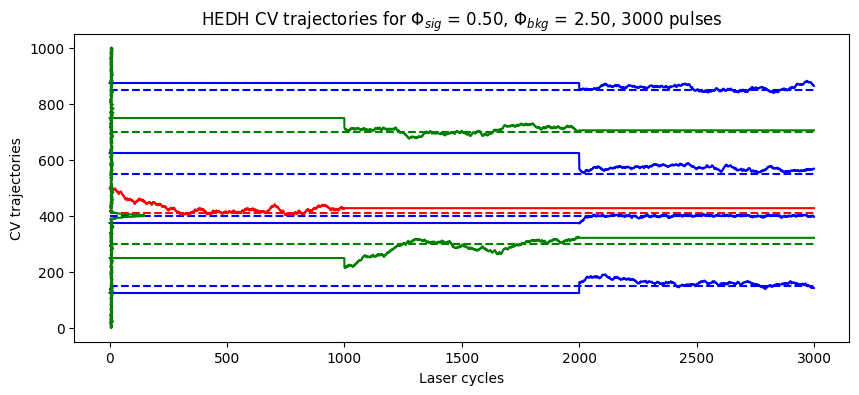

In [68]:
from SPCSim.sensors import HEDHBaseClass
from SPCSim.utils import plot_transient, plot_edh, plot_edh_traj


phi_bar = tr_gen.get_transient(data["gt_dist"],
                               data["albedo"],
                               data["albedo"],
                               data["alpha_sig"],
                               data["alpha_bkg"])


# Setting the dimensions, device, number of EWH bins per pixel
# and number of laser pulses

Nr, Nc, N_tbins = phi_bar.shape
device = PixLdr.device
N_edhbins = 8
N_pulses = 3000

spc1 = HEDHBaseClass(Nr,
              Nc,
              N_pulses,
              device,
              N_tbins,
              N_edhbins,
              step_params={
                  "k":2,
                  "step_vals":[1],
              })

captured_data = spc1.capture(phi_bar)

pedh_data = captured_data["edh"]
gtedh_data = captured_data["gtedh"]
ewh_data = captured_data["ewh"]
edh_list = captured_data["traj"]
edh_list = np.array(edh_list)

ROW, COL = [0,0]

fig, ax = plt.subplots(1,1, figsize=(6,4))
ymax = ((torch.sum(ewh_data[ROW,COL,:])/N_edhbins)).item()
plot_edh(pedh_data[ROW,COL,:].cpu().numpy(),
         ax,
         ymax = ymax)
plot_edh(gtedh_data[ROW,COL,:].cpu().numpy(), ax,
         tr = phi_bar[ROW, COL,:].numpy()*spc1.N_pulses,
        #  crop_window= tr_gen.FWHM*1.5*tr_gen.N_tbins*1.0/tr_gen.tmax,
         ymax = ymax, ls='--')
ax.set_title(r'Final EDH boundaries for $\Phi_{sig}$ = %.2f, $\Phi_{bkg}$ = %.2f, %d pulses'%(data["alpha_sig"][ROW,COL], data["alpha_bkg"][ROW,COL], spc1.N_pulses))
# fig.savefig("Temp.png")

fig1, ax1 = plt.subplots(1,1, figsize=(10,4))
plot_edh_traj(ax1, edh_list, gtedh_data[ROW,COL,1:-1], ewh_data[0,0,:].cpu().numpy())
ax1.set_title(r'HEDH CV trajectories for $\Phi_{sig}$ = %.2f, $\Phi_{bkg}$ = %.2f, %d pulses'%(data["alpha_sig"][ROW,COL], data["alpha_bkg"][ROW,COL], spc1.N_pulses))
# fig1.savefig("TempTraj.png")


## Simulate proportional EDH SPCs

The `PEDHBaseClass` simulates the proportional ED histogrammers [[2]](https://link.springer.com/chapter/10.1007/978-3-031-73039-9_22). PEDH uses a proportional binner circuit to track the ED histogram boundaries without storing the photon timestamps.

In [69]:
from SPCSim.sensors import PEDHBaseClass
from SPCSim.utils import plot_transient, plot_edh, plot_edh_traj

# Generate the per pixel data
data = PixLdr.get_data()

# Creating transient generator with laser time period of 100ns, FWHM 1 and with
# laser time period divided into 1000 equal time-bins
tr_gen = TransientGenerator(N_tbins = 1000, tmax = PixLdr.tmax, FWHM = 1)


# Using the get function to generate the transient
# for a given distance, albedo, intensity, and illumination condition
phi_bar = tr_gen.get_transient(data["gt_dist"],
                               data["albedo"],
                               data["albedo"],
                               data["alpha_sig"],
                               data["alpha_bkg"])

In [70]:

# Setting the dimensions, device, number of EWH bins per pixel
# and number of laser pulses
Nr, Nc, N_tbins = phi_bar.shape
device = PixLdr.device
N_edhbins = 16
N_pulses = 5000
print(N_pulses)

spc1 = PEDHBaseClass(Nr,
              Nc,
              N_pulses,
              device,
              N_tbins,
              N_edhbins,
              step_params={
                  "k":1
              })

captured_data = spc1.capture(phi_bar)

pedh_data = captured_data["edh"]
gtedh_data = captured_data["gtedh"]
ewh_data = captured_data["ewh"]
edh_list = captured_data["traj"]
edh_list = np.array(edh_list)

5000


100%|██████████| 5000/5000 [00:13<00:00, 378.76it/s]


(5000, 15)
torch.Size([15])


Text(0.5, 1.0, 'PEDH CV trajectories for $\\Phi_{sig}$ = 0.50, $\\Phi_{bkg}$ = 2.50, 5000 pulses')

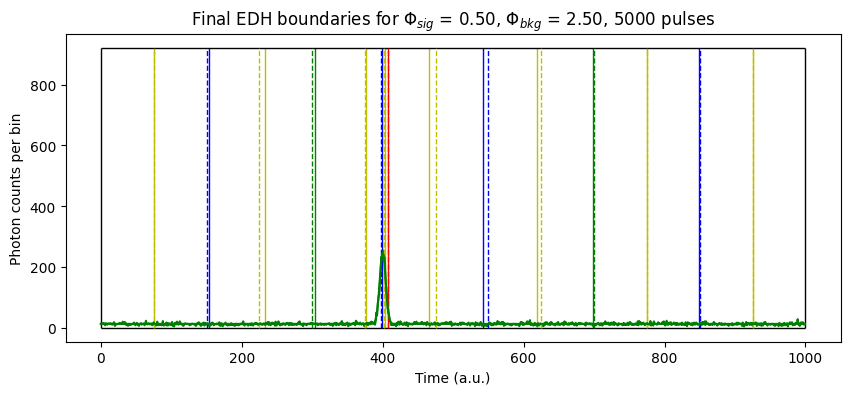

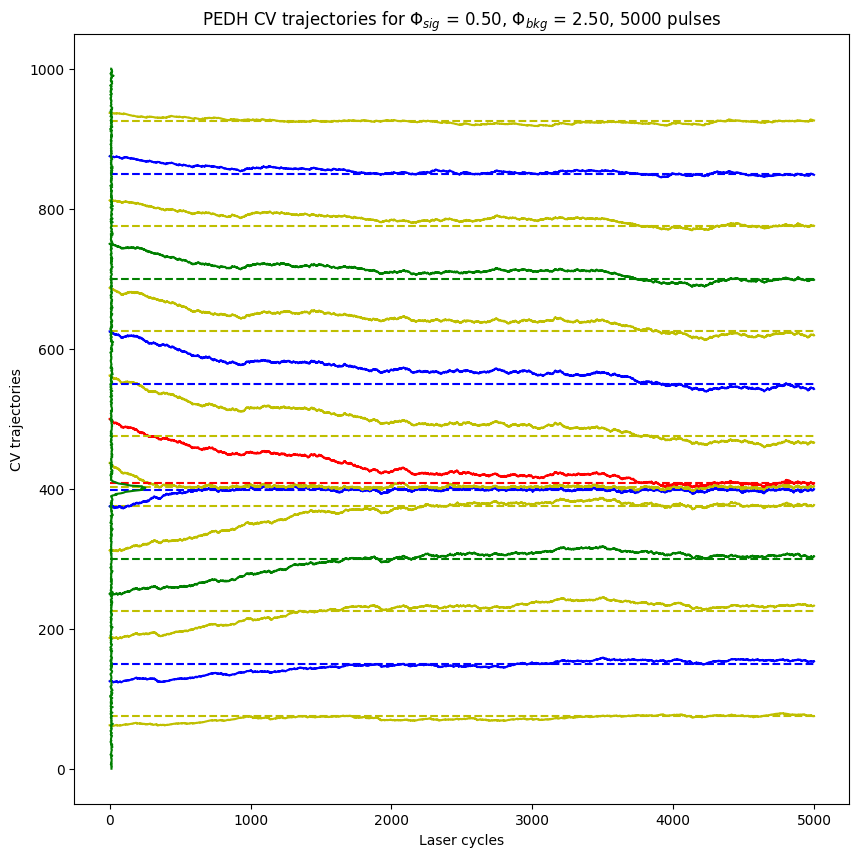

In [71]:
ROW, COL = [0,0]

fig, ax = plt.subplots(1,1, figsize=(10,4))
ymax = ((torch.sum(ewh_data[ROW,COL,:])/N_edhbins)).item()
plot_edh(pedh_data[ROW,COL,:],
         ax,
         tr = ewh_data[ROW, COL,:].numpy(),
         ymax = ymax)
plot_edh(gtedh_data[ROW,COL,:], ax,
         tr = phi_bar[ROW, COL,:].numpy()*spc1.N_pulses,
        #  crop_window= tr_gen.FWHM*1.5*tr_gen.N_tbins*1.0/tr_gen.tmax,
         ymax = ymax, ls='--')
ax.set_title(r'Final EDH boundaries for $\Phi_{sig}$ = %.2f, $\Phi_{bkg}$ = %.2f, %d pulses'%(data["alpha_sig"][ROW,COL], data["alpha_bkg"][ROW,COL], spc1.N_pulses))

fig1, ax1 = plt.subplots(1,1, figsize=(10,10))
plot_edh_traj(ax1, edh_list, gtedh_data[ROW,COL,1:-1], ewh_data[0,0,:].cpu().numpy())
ax1.set_title(r'PEDH CV trajectories for $\Phi_{sig}$ = %.2f, $\Phi_{bkg}$ = %.2f, %d pulses'%(data["alpha_sig"][ROW,COL], data["alpha_bkg"][ROW,COL], spc1.N_pulses))


**********
References
**********

[1] A. Ingle and D. Maier, "Count-Free Single-Photon 3D Imaging with Race Logic," in IEEE Transactions on Pattern Analysis and Machine Intelligence, doi: 10.1109/TPAMI.2023.3302822,

[2] Sadekar, K., Maier, D., & Ingle, A. (2025). Single-Photon 3D Imaging with Equi-Depth Photon Histograms. In European Conference on Computer Vision (pp. 381-398). Springer, Cham.
